In [1]:
import os
from pathlib import Path
from tqdm import tqdm
import json

import numpy as np # linear algebra
import pandas as pd
#pd.set_option("display.max_rows", 101)
import math

import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 10
import seaborn as sns
from PIL import Image

from collections import Counter
from collections import defaultdict

from keras.layers import *
from keras.models import Model
from keras.optimizers import *
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
DIRin1 = "../input/severstal-steel-defect-detection"
print("DIRin1 =", os.listdir(DIRin1))
DIRtrain = os.path.join(DIRin1,"train_images")
DIRtest = os.path.join(DIRin1,"test_images")

DIRin2 = "../input/train-excel"
print("DIRin2 =", os.listdir(DIRin2))
# save path
weights_path = os.path.join(DIRin2,"DefectDetection.h5")
history_path = os.path.join(DIRin2,"DefectDetection_history.csv")

print("Num of Train img\t:",len(os.listdir(DIRtrain)))
print("Num of Test img\t\t:",len(os.listdir(DIRtest)))

DIRin1 = ['test_images', 'train.csv', 'train_images', 'sample_submission.csv']
DIRin2 = ['train.csv']
Num of Train img	: 12568
Num of Test img		: 5506


In [28]:
##### Training conditions ##### 
batch_size = 16

NoTRAIN = True    # True:No further training, use pre-learned weights
RESUME = False    # True:Resume Training, False:Start from the beginning

epochs = 40
steps_per_epoch = 200

In [4]:
train_df = pd.read_csv(os.path.join(DIRin2, "train.csv"))
train_df.head()

,ImageId,ClassId,EncodedPixels,ImageId_ClassId
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg_1
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,0007a71bf.jpg_3
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,000a4bcdd.jpg_1
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,000f6bf48.jpg_4
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,0014fce06.jpg_3


In [5]:
# Transform class to column
train_df['fname'], train_df['cls'] = zip(*train_df['ImageId_ClassId'].str.split('_'))
train_df['cls'] = train_df['cls'].astype(int)
train_df = train_df.pivot(index='fname',columns='cls',values='EncodedPixels')
train_df['defects'] = train_df.count(axis=1)
#train_df.reset_index()
train_df.head(10)

cls,1,2,3,4,defects
fname,,,,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN,1
0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN,1
000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,NaN,NaN,NaN,1
000f6bf48.jpg,NaN,NaN,NaN,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
0014fce06.jpg,NaN,NaN,229501 11 229741 33 229981 55 230221 77 230468...,NaN,1
0025bde0c.jpg,NaN,NaN,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,315139 8 315395 15 315651 16 315906 17 316162 ...,2
002af848d.jpg,NaN,NaN,NaN,290800 6 291055 13 291311 15 291566 18 291822 ...,1
002fc4e19.jpg,146021 3 146275 10 146529 40 146783 46 147038 ...,145658 7 145901 20 146144 33 146386 47 146629 ...,NaN,NaN,2
0030401a5.jpg,NaN,NaN,NaN,186833 1 187089 3 187344 6 187600 7 187855 10 ...,1


In [6]:
# Presence of defects in each images
no_defects_num = np.sum(train_df['defects'] == 0)
defects_num = len(train_df) - no_defects_num
print("no_defect imgs \t:", no_defects_num)
print("defects imgs \t:", defects_num)

no_defect imgs 	: 0
defects imgs 	: 6666


In [7]:
# Number of defects for each class
class_defects = len(train_df) - train_df.isnull().sum() # class毎の欠陥数
class_defects[:4]

cls
1     897
2     247
3    5150
4     801
dtype: int64

In [8]:
# check images size
train_size = defaultdict(int)
test_size = defaultdict(int)

for fPath in Path(DIRtrain).iterdir():
    img = Image.open(fPath)
    train_size[img.size] += 1
for fPath in Path(DIRtest).iterdir():
    img = Image.open(fPath)
    test_size[img.size] += 1
    
print("train_img_size :",train_size)
print("test_img_size  :",test_size)

train_img_size : defaultdict(<class 'int'>, {(1600, 256): 12568})
test_img_size  : defaultdict(<class 'int'>, {(1600, 256): 5506})


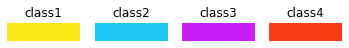

In [9]:
palet = [(250, 230, 20), (30, 200, 241), (200, 30, 250), (250,60,20)]

fig, ax = plt.subplots(1, 4, figsize=(6, 2))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((10, 40, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class{}".format(i+1))

plt.show()

In [10]:
def mask2rgba(mask):
    rgba_list = []
    for idx in range(4):    # idx: class id
        rgba = cv2.cvtColor(mask[:, :, idx], cv2.COLOR_GRAY2RGBA)
        rgba[:, :, :3] = rgba[:, :, :3] /255 * palet[idx]
        rgba_list.append(rgba)
    return rgba_list
def make_mask(row_id):
    fname = train_df.iloc[row_id].name

    labels = train_df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.uint8)    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 255
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks
def show_mask_image(row_id, contour = True):
    name, mask = make_mask(row_id)
    img = cv2.imread(os.path.join(DIRtrain, name))

    if contour:
        for ch in range(4):
            contours, _ = cv2.findContours(mask[:, :, ch],
                            cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            for i in range(0, len(contours)):
                cv2.polylines(img, contours[i], True, palet[ch], 2)
    else:
        for ch in range(4):
            img[mask[:,:,ch]==255] = palet[ch]
        
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_title(name)
    ax.imshow(img)
    ax.axis('off')
    plt.show()
# classify defects
idx_class_1 = list(filter(lambda r:not pd.isna(train_df.iloc[r,0]), range(len(train_df))))
idx_class_2 = list(filter(lambda r:not pd.isna(train_df.iloc[r,1]), range(len(train_df))))
idx_class_3 = list(filter(lambda r:not pd.isna(train_df.iloc[r,2]), range(len(train_df))))
idx_class_4 = list(filter(lambda r:not pd.isna(train_df.iloc[r,3]), range(len(train_df))))
# Nouber of defects class
idx_no_defect = list(filter(lambda r:train_df.iloc[r,4] == 0, range(len(train_df))))
idx_1_defect = list(filter(lambda r:train_df.iloc[r,4] == 1, range(len(train_df))))
idx_class_multi = list(filter(lambda r:train_df.iloc[r,4] >= 2, range(len(train_df))))

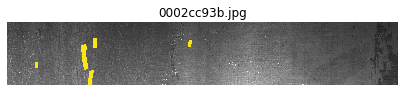

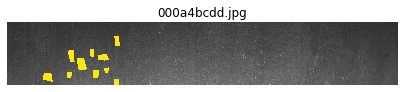

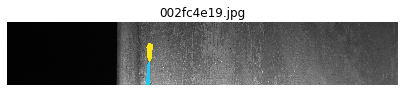

In [11]:
# class_1 defect sumple (Yellow)
for idx in idx_class_1[:3]:
    show_mask_image(idx, contour=False)

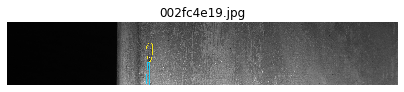

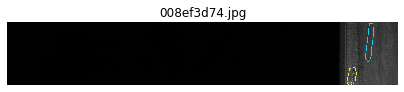

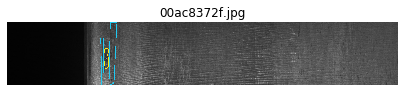

In [12]:
# class_2 defect sumple (lightblue)
for idx in idx_class_2[:3]:
    show_mask_image(idx, contour=True)

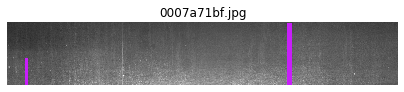

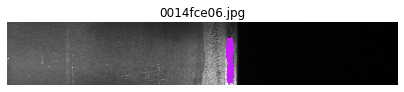

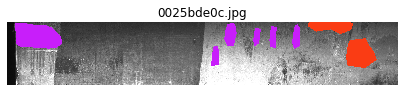

In [13]:
# class_3 defect sumple (purple)
for idx in idx_class_3[:3]:
    show_mask_image(idx, contour=False)

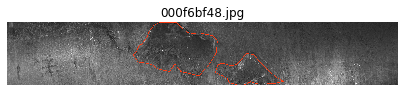

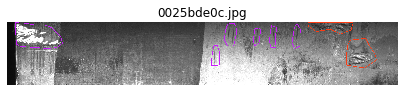

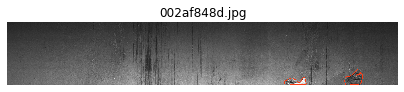

In [14]:
# class_4 defect sumple (red)
for idx in idx_class_4[:3]:
    show_mask_image(idx, contour=True)

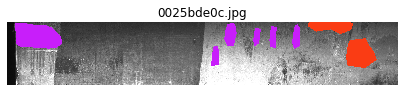

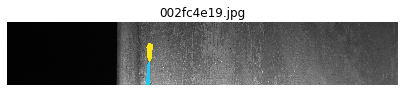

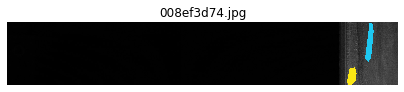

In [15]:
# contain multi class defects
for idx in idx_class_multi[:3]:
    show_mask_image(idx, contour=False)

In [16]:
# U-Net
# https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data#Vanilla-Unet

input_shape = (256, 1600, 1)
inputs = Input(input_shape)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
u6 = concatenate([u6, c5])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

# Load pre-traind weights
if (NoTRAIN or RESUME) and os.path.exists(weights_path):
    model.load_weights(weights_path)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 1600, 8) 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 800, 8)  0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [17]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) \
            / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
optimizer = Adam()
model.compile(optimizer, 'binary_crossentropy', metrics=[dice_coef])

X.shape: (4, 256, 1600, 1) 
y.shape: (4, 256, 1600, 4)


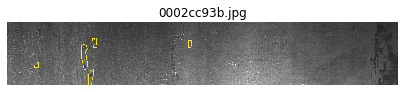

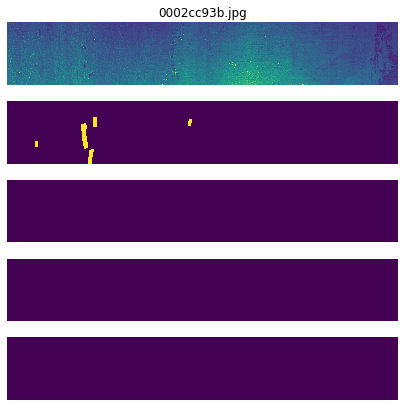

In [18]:
# Train Data Generator
def Xy_generator(ids, batch_size):
    Xs = []; ys = []
    while True:
        for i in ids:
            name, mask = make_mask(i)
            img = cv2.imread(os.path.join(DIRtrain, name),
                             cv2.IMREAD_GRAYSCALE)
            img = img[..., np.newaxis]    # Add channel axis
            img = img / 255.           # 0～1
            mask = mask / 255.         # 0～1
            Xs.append(img); ys.append(mask)
            if len(Xs) == batch_size:
                X = np.array(Xs); y = np.array(ys)
                Xs = []; ys = []
                yield [X, y]
# Train Data
train_ids, val_ids = train_test_split(range(len(train_df)), test_size=0.2)
train_gen = Xy_generator(train_ids, batch_size)
val_gen = Xy_generator(val_ids, batch_size)
# generator test
for X, y in Xy_generator(range(len(train_df)), 4):
    break

print('X.shape:',X.shape, '\ny.shape:',y.shape)

row = 0
# from train_df
show_mask_image(row, contour=True)
# from generator
fig, axs = plt.subplots(5, figsize=(7,7))
axs[0].imshow(X[row,:,:,0])
axs[0].axis('off')
axs[0].set_title(train_df.iloc[row].name)
for i in range(4):
    axs[i+1].imshow(y[row,:,:,i])
    axs[i+1].axis('off')

In [20]:
# Callback
checkpoint = ModelCheckpoint("DefectDetection.h5", monitor='val_dice_coef',
                             verbose=1,save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [29]:
history = model.fit_generator(generator=train_gen,
                              steps_per_epoch=steps_per_epoch,
                              initial_epoch=initial_epoch,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps = len(val_ids)//batch_size,
                              verbose=2,
                              shuffle=True,
                              callbacks=callbacks_list)

Epoch 1/40
 - 123s - loss: 0.0657 - dice_coef: 0.0711 - val_loss: 0.0688 - val_dice_coef: 0.1012

Epoch 00001: val_dice_coef improved from -inf to 0.10122, saving model to DefectDetection.h5
Epoch 2/40
 - 119s - loss: 0.0535 - dice_coef: 0.1224 - val_loss: 0.0587 - val_dice_coef: 0.1408

Epoch 00002: val_dice_coef improved from 0.10122 to 0.14076, saving model to DefectDetection.h5
Epoch 3/40
 - 118s - loss: 0.0469 - dice_coef: 0.1929 - val_loss: 0.0501 - val_dice_coef: 0.2570

Epoch 00003: val_dice_coef improved from 0.14076 to 0.25703, saving model to DefectDetection.h5
Epoch 4/40
 - 119s - loss: 0.0436 - dice_coef: 0.2680 - val_loss: 0.0426 - val_dice_coef: 0.2755

Epoch 00004: val_dice_coef improved from 0.25703 to 0.27549, saving model to DefectDetection.h5
Epoch 5/40
 - 119s - loss: 0.0392 - dice_coef: 0.3005 - val_loss: 0.0361 - val_dice_coef: 0.3366

Epoch 00005: val_dice_coef improved from 0.27549 to 0.33658, saving model to DefectDetection.h5
Epoch 6/40
 - 120s - loss: 0.0398

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


 - 165s - loss: 0.0234 - dice_coef: 0.5610 - val_loss: 0.0434 - val_dice_coef: 0.5489

Epoch 00027: val_dice_coef improved from 0.54069 to 0.54893, saving model to DefectDetection.h5
Epoch 28/40
 - 117s - loss: 0.0227 - dice_coef: 0.5681 - val_loss: 0.0462 - val_dice_coef: 0.5481

Epoch 00028: val_dice_coef did not improve from 0.54893
Epoch 29/40
 - 118s - loss: 0.0237 - dice_coef: 0.5631 - val_loss: 0.0243 - val_dice_coef: 0.5164

Epoch 00029: val_dice_coef did not improve from 0.54893
Epoch 30/40
 - 118s - loss: 0.0227 - dice_coef: 0.5578 - val_loss: 0.0428 - val_dice_coef: 0.5434

Epoch 00030: val_dice_coef did not improve from 0.54893
Epoch 31/40
 - 118s - loss: 0.0229 - dice_coef: 0.5757 - val_loss: 0.0385 - val_dice_coef: 0.5605

Epoch 00031: val_dice_coef improved from 0.54893 to 0.56047, saving model to DefectDetection.h5
Epoch 32/40
 - 118s - loss: 0.0223 - dice_coef: 0.5840 - val_loss: 0.0356 - val_dice_coef: 0.5392

Epoch 00032: val_dice_coef did not improve from 0.56047
Ep

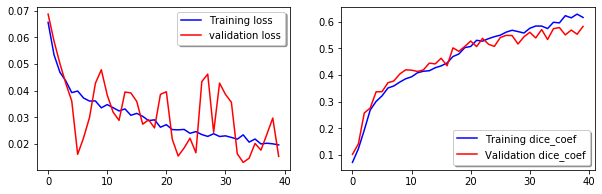

In [32]:

    hist_df = pd.DataFrame(history.history)[['loss','val_loss','dice_coef','val_dice_coef']]

# Plot
fig, ax = plt.subplots(1,2,figsize=(10, 3))

ax[0].plot(hist_df['loss'], color='b', label="Training loss")
ax[0].plot(hist_df['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist_df['dice_coef'], color='b', label="Training dice_coef")
ax[1].plot(hist_df['val_dice_coef'], color='r',label="Validation dice_coef")
legend = ax[1].legend(loc='best', shadow=True)


In [33]:
# Save history (for next Resume)
hist_df.to_csv("DefectDetection_history.csv", index=False)

**Predict**

In [34]:
# Load the weights that had the best score for predict
if NoTRAIN == False or RESUME:
    model.load_weights("DefectDetection.h5")

In [35]:
# Binarize the mask output by NN
def binarize(masks, th = 0.5):
    # Maximum value of each channel per pixel
    mask_max = np.zeros_like(masks[:,:,0])
    mask_max = np.fmax(masks[:,:,0],masks[:,:,1])
    mask_max = np.fmax(mask_max,masks[:,:,2])
    mask_max = np.fmax(mask_max,masks[:,:,3])
    # Remove non-maximum pixels
    m = np.zeros_like(masks)
    for ch in range(4):
        m[:,:,ch] = (masks[:,:,ch] == mask_max) * masks[:,:,ch]
    # Binarization
    m = (m>th) * 1
    return m

In [36]:
def show_predict_img(df, row):
    if df == "train_df":
        name = train_df.iloc[row].name
        img = cv2.imread(os.path.join(DIRtrain, name),
                             cv2.IMREAD_GRAYSCALE)
    else:
        if df == "submit_df":
            name = test_df.iloc[row//4,0].split('_')[0]
        elif df == "test_df":
            name = test_df.iloc[row,0]
        img = cv2.imread(os.path.join(DIRtest, name),
                             cv2.IMREAD_GRAYSCALE)

    img_ = img[..., np.newaxis]    # Add channel axis
    img_ = img_[np.newaxis, ...]    # Add batch axis
    img_ = img_ / 255.              # 0～1

    pred_masks = model.predict(img_)
    bin_masks = binarize(pred_masks[0, ...], 0.5)

    fig, axs = plt.subplots(5,2, figsize=(12, 6))
    axs[0,0].imshow(img)
    axs[0,0].axis('off')
    axs[0,0].set_title(name)
    axs[0,1].axis('off')
    axs[0,1].set_title("after binarize")
    for i in range(4):
        axs[i+1,0].imshow(pred_masks[0,:,:,i])
        axs[i+1,0].axis('off')
        axs[i+1,0].set_title('class '+ str(i+1))
        axs[i+1,1].imshow(bin_masks[:,:,i])
        axs[i+1,1].axis('off')
        axs[i+1,1].set_title('class '+ str(i+1))

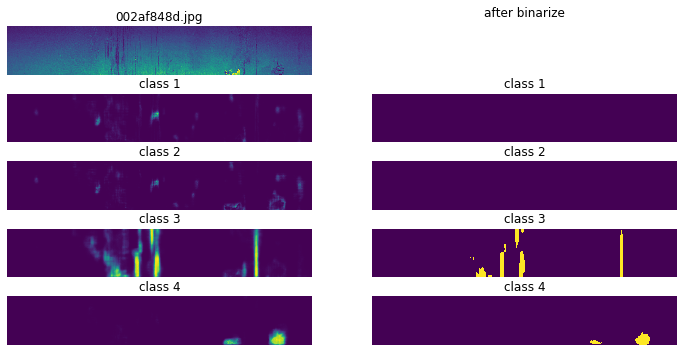

In [37]:
# predict sumple
show_predict_img("train_df", 6)

In [38]:
submit_df = pd.read_csv(os.path.join(DIRin1,'sample_submission.csv'))
submit_df['EncodedPixels'] = np.nan
submit_df.head(5)

,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,NaN,0
1,000ccc2ac.jpg,NaN,0
2,002451917.jpg,NaN,0
3,003c5da97.jpg,NaN,0
4,0042e163f.jpg,NaN,0


In [39]:
temp_df = pd.DataFrame()
temp_df['ImageId'] = submit_df['ImageId']
test_df = pd.DataFrame(temp_df['ImageId'].unique(), columns=['ImageId'])
test_df.head()

,ImageId
0,0000f269f.jpg
1,000ccc2ac.jpg
2,002451917.jpg
3,003c5da97.jpg
4,0042e163f.jpg


In [40]:
def mask2rle(mask):
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[:-1:2]
    return ' '.join(str(x) for x in runs)

In [41]:
def build_rles(masks):
    width, height, depth = masks.shape
    masks = binarize(masks, th = 0.5)
    rles = [mask2rle(masks[:, :, i]) for i in range(depth)]

    return rles

In [42]:
# Predict test images
for i, line in tqdm(test_df.iterrows()):
    img = cv2.imread(os.path.join(DIRtest, line['ImageId']),
                     cv2.IMREAD_GRAYSCALE)
    img = img[..., np.newaxis]    # Add channel axis
    img = img[np.newaxis, ...]    # Add butch axis
    img = img / 255.              # 0～1
    pred_masks = model.predict(img)[0]
    rles = build_rles(pred_masks)
    for j in range(4):
        if len(rles[j])>0:
            submit_df.iloc[i*4+j,1] = rles[j]

1374it [00:49, 28.10it/s]

IndexError: single positional indexer is out-of-bounds

In [43]:
submit_df.head(30)


,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,NaN,0
1,000ccc2ac.jpg,NaN,0
2,002451917.jpg,115271 8 115510 7 115518 1 115525 12 115757 2 ...,0
3,003c5da97.jpg,NaN,0
4,0042e163f.jpg,NaN,0
5,004f40c73.jpg,NaN,0
6,00513039a.jpg,NaN,0
7,006f39c41.jpg,NaN,0
8,008725cbc.jpg,NaN,0
9,0098ca44e.jpg,NaN,0


1374it [00:59, 28.10it/s]

In [44]:
# Number of Defect Detection
submit_df['EncodedPixels'].count()

1344

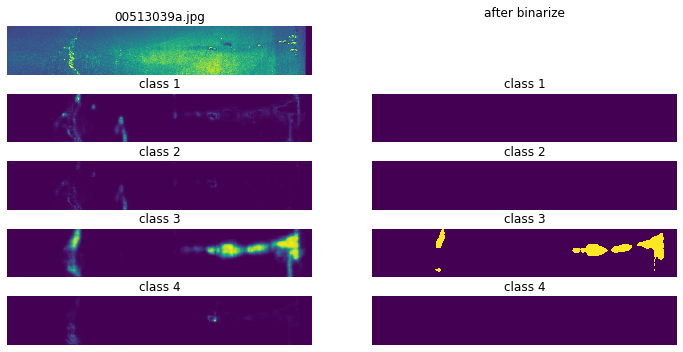

In [45]:
# Detected sumple
show_predict_img("submit_df",26)

In [46]:
submit_df.to_csv('submission.csv', index=False)


In [58]:
def take_input_predict_img(img_path):
    if img_path == "../input/severstal-steel-defect-detection/test_images/00a0b7730.jpg":
        
        img = cv2.imread("../input/severstal-steel-defect-detection/test_images/00a0b7730.jpg",
                             cv2.IMREAD_GRAYSCALE)
    img_ = img[..., np.newaxis]    # Add channel axis
    img_ = img_[np.newaxis, ...]    # Add batch axis
    img_ = img_ / 255.              # 0～1

    pred_masks = model.predict(img_)
    bin_masks = binarize(pred_masks[0, ...], 0.5)

    fig, axs = plt.subplots(5,2, figsize=(12, 6))
    axs[0,0].imshow(img)
    axs[0,0].axis('off')
   # axs[0,0].set_title(name)
    axs[0,1].axis('off')
    axs[0,1].set_title("after binarize")
    for i in range(4):
        axs[i+1,0].imshow(pred_masks[0,:,:,i])
        axs[i+1,0].axis('off')
        axs[i+1,0].set_title('class '+ str(i+1))
        axs[i+1,1].imshow(bin_masks[:,:,i])
        axs[i+1,1].axis('off')
        axs[i+1,1].set_title('class '+ str(i+1))


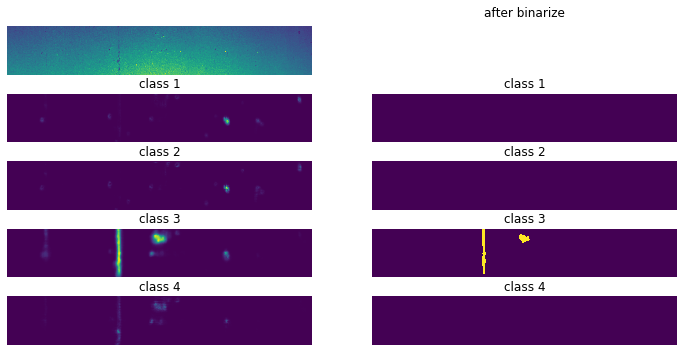

In [59]:
take_input_predict_img("../input/severstal-steel-defect-detection/test_images/00a0b7730.jpg")